<a href="https://colab.research.google.com/github/kregier/AudioLanguageClassifer/blob/main/GenderClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook reads in audio files, splits the files into 10s segments, adds random noise to the training files, extracts vggish embeddings, and runs the embeddings through a binary gender classifier.

This classifier is trained on the entire audio database - speakers from around 200 different languages, reading passages in English.

## Goal:
Identify the gender of the speaker from an audio file.

## Process
Split data into train and test sets
For **all** audio files, segment into 10s segments.
For **training** data, copy segments and add random noise.

Load the VGGish model.

Create dataset generators to process the files in batches. The data generator runs the segments through the VGGish model and extract the feature embeddings, which are used as input to the classifier model.

## Run the model
## Evaluate the model

# Set up the environment

In [1]:
# Set up the environment
#!pip install pyAudioAnalysis
#!pip install hmmlearn
#!pip install eyed3
#!pip install pydub
!pip install soundfile

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
#import librosa.display
import soundfile as sf

#from pyAudioAnalysis import audioSegmentation as aS

import os
import random
import re

import tensorflow as tf
import tensorflow_hub as hub

from keras.layers import Dense
from keras.models import Sequential

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print("All set up!")

All set up!


To run the model on Colab GPU, go to Runtime/ Change runtime type and select GPU.

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Set up the data import using Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# Change working directory
%cd /content/gdrive/My Drive/Kaggle
!ls

/content/gdrive/My Drive/Kaggle
augment  kaggle.json  processed.csv	   recordings
data	 model	      reading-passage.txt  speakers_all.csv


In [5]:
# Import custom functions that I wrote
import augment
from augment import Augment

from imp import reload
#reload(augment)
#reload(augment.Augment)

Module imported
Augment scripts reloaded


In [6]:
# Set constants
SAMP_RATE = 16000  #Defined in augment package
BATCH_SIZE = 32  #Defined in augment package
CLF = 'gender'

#  Load the data
## Load the metadata

In [7]:
meta = pd.read_csv('processed.csv', index_col='speakerid')
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


In [8]:
meta.shape

(2134, 8)

In [9]:
meta.isnull().sum()

age                0
age_onset          0
birthplace         0
filename           0
native_language    0
sex                0
country            0
file_missing?      0
dtype: int64

# Data processing
## Split into training and testing sets

In [10]:
# Split data into training and testing sets for gender analysis
data = meta[['filename','sex']]
x_train_names, x_test_names, y_train, y_test = train_test_split(
    data['filename'], data['sex'], test_size=0.25, random_state=38, 
    stratify=data['sex'])

In [11]:
print("Number of training files: ", x_train_names.shape)
print("Number of testing files: ", x_test_names.shape)

Number of training files:  (1600,)
Number of testing files:  (534,)


## Segment the audio files into 10s segments
This takes a bit of time, but should only need to be done once.

In [12]:
# Check if training data has been segmented. If not, segment each audio file.
train_file_list = os.listdir('data/gender/train')

for i in range(len(x_train_names)):
  # get a filename
  filename = x_train_names.iloc[i]
  # Check to see if the filename has already been segmented
  if any(file.startswith(filename) for file in train_file_list):
    pass
  else: 
    augment.Augment.segment_audio(x_train_names.iloc[i], y_train.iloc[i], split='train', clf=CLF)
    print('{} segmented'.format(filename))

In [13]:
# Check if testing data has been segmented. If not, segment each audio file.
test_file_list = os.listdir('data/gender/test')
for i in range(len(x_test_names)):
  filename = x_test_names.iloc[i]
  if any(file.startswith(filename) for file in test_file_list):
    pass
  else: 
    augment.Augment.segment_audio(x_test_names.iloc[i], y_test.iloc[i], split='test', clf=CLF)
    print('{} segmented'.format(filename))

In [14]:
# Generate a list training filenames + segment index to input to add_noise() function
x_train_seg = [x.split('o.wav')[0] for x in os.listdir('data/gender/train') if x.endswith('o.wav')]
print(len(x_train_seg))

3460


In [15]:
print(x_train_seg[:BATCH_SIZE])

['russian31.M.0', 'portuguese34.M.0', 'portuguese34.M.1', 'danish3.F.0', 'taiwanese7.F.0', 'taiwanese7.F.1', 'taiwanese7.F.2', 'taiwanese7.F.3', 'swedish17.F.0', 'swedish17.F.1', 'spanish62.F.0', 'spanish62.F.1', 'spanish62.F.2', 'ngemba1.M.0', 'ngemba1.M.1', 'ngemba1.M.2', 'romanian4.F.0', 'romanian4.F.1', 'arabic23.M.0', 'arabic23.M.1', 'bengali13.F.0', 'bengali13.F.1', 'hungarian6.F.0', 'hungarian6.F.1', 'hungarian6.F.2', 'spanish122.F.0', 'spanish122.F.1', 'russian24.F.0', 'russian24.F.1', 'russian24.F.2', 'korean25.F.0', 'korean25.F.1']


In [16]:
# Generate a list testing filenames + segment index
x_test_seg = [x.split('o.wav')[0] for x in os.listdir('data/gender/test') if x.endswith('o.wav')]
print(len(x_test_seg))

1206


## Add noise to segments in training set
Not necesary for testing set

In [17]:
# Check if training data has been augmented with noise. If not, add noise to each segment.
noise_train_list = os.listdir('data/gender/train')
for i in range(len(x_train_seg)):
  filename = x_train_seg[i]
  if any((file.startswith(filename)& file.endswith('n.wav')) for file in noise_train_list):
    pass
  else: 
    augment.Augment.noisy_data(x_train_seg[i], split='train', clf=CLF)
    print('{} augmented'.format(filename))

In [18]:
# Verify there are equal numbers for original segments and noisy segments.
x_train_noise = [x.split('n.wav')[0] for x in os.listdir('data/gender/train') if x.endswith('n.wav')]
print(len(x_train_seg) == len(x_train_noise))

True


## Format input lists for generator

In [19]:
x_train_filenames = os.listdir('data/gender/train')
x_train_filepaths = ['data/gender/train/{}'.format(i) for i in x_train_filenames]
print(x_train_filepaths[:5])
print(len(x_train_filepaths))

['data/gender/train/english167.M.0n.wav', 'data/gender/train/english167.M.1n.wav', 'data/gender/train/english66.M.0n.wav', 'data/gender/train/english66.M.1n.wav', 'data/gender/train/hausa6.M.0n.wav']
6920


In [20]:
x_test_filenames = os.listdir('data/gender/test')
x_test_filepaths = ['data/gender/test/{}'.format(i) for i in x_test_filenames]
#print(x_test_filepaths[:5])
print(len(x_test_filepaths))

1206


## Load VGGish model
Generate a dataset to check the funtionality of the generator before applying to the larger dataset

In [21]:
# Using a SavedModel from the TFHub in Keras
# https://www.tensorflow.org/hub/tf2_saved_model
# VGGish model, from https://tfhub.dev/google/vggish/1

# Link to the model on TFHub
hub_url = 'https://tfhub.dev/google/vggish/1'

# Load the model as a Keras model
vggish_model = hub.KerasLayer(hub_url)
vggish_model.trainable = False

In [22]:
# Run one file through the model to get output shape
#import librosa
audio, sr = librosa.load(x_train_filepaths[0], SAMP_RATE)
sample = vggish_model(audio)
print(sample.shape)

(10, 128)


## Create and test the data generator

In [23]:
def tf_data_generator(file_list, batch_size=32):
    """ Create a dataset generator. 
    Iterate through a list of filenames and process in batches.
    Extract audio features from vggish model.
    WARNING: This generator forms an infinite loop, 
    so you need to specify how long to run the generator 
    before fitting and evaluating a model.

    Arguments:
    file_list - list of filenames to iterate
    vggish_model  - pass the instantiated model to the function
    batch_size - how many files to process at a time
    """
    i = 0
    while True: #infinite loop
        if i*batch_size >= len(file_list):
            i=0
            np.random.shuffle(file_list)
        else:
            file_chunk = file_list[i*batch_size:(i+1)*batch_size]
            data = []
            labels = []
            label_classes = tf.constant(['M', 'F'])
            for file in file_chunk:
                # Read data
                audio, sr = librosa.load(file, sr=16000)
                # Apply transformations
                embed = vggish_model(audio)
                data.append(embed)
                # Extract labels from filename
                bytes_string = file
                string_name = str(bytes_string, 'utf-8')
                split_str = string_name.split('.')
                #print(split_str)
                pattern = tf.constant(split_str[1])
                #print(pattern)
                for j in range(len(label_classes)):
                    if re.match(pattern.numpy(), label_classes[j].numpy()):
                        labels.append(j)

            data = np.asarray(data)
            labels = np.asarray(labels)

            yield data, labels
            i += 1

In [24]:
dataset_check = tf.data.Dataset.from_generator(tf_data_generator,
                                         args = [x_train_filepaths[:2*BATCH_SIZE], BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) )

In [25]:
# Check shape and size of dataset batches
for data, labels in dataset_check.take(2):
  print(data.shape)
  print(labels)

(32, 10, 128)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 1. 0.], shape=(32,), dtype=float32)
(32, 10, 128)
tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 1.], shape=(32,), dtype=float32)


## Generate training, validation and testing datasets

In [26]:
x_train, x_val = train_test_split(x_train_filepaths, test_size=.25, random_state=38)

In [27]:
# Print sizes of data splits
print("Number of training samples: ", len(x_train))
print("Number of validation samples: ", len(x_val))
print("Number of testing samples: ", len(x_test_seg))

Number of training samples:  5190
Number of validation samples:  1730
Number of testing samples:  1206


In [28]:
train_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [x_train, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) ) 
validation_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [x_val, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) )
test_dataset = tf.data.Dataset.from_generator(tf_data_generator, 
                                         args = [x_test_filepaths, BATCH_SIZE],
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes= ((None, 10, 128),(None,)) ) 

# Build and compile the classifier model

In [29]:
# Look for a GPU parameter in the model parameters, add to model.

genderClf = tf.keras.models.Sequential([tf.keras.layers.Dense(128, activation = 'relu', input_shape=(10, 128)),
                              tf.keras.layers.Dense(64, activation = 'relu'),
                              tf.keras.layers.Dense(1, activation='sigmoid'),
                              tf.keras.layers.AveragePooling1D(pool_size=10, strides=None, padding="valid", data_format="channels_last")
                              ])
genderClf.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [30]:
# Add early stopping to train classifier model; default is 10 epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

In [31]:
# Add model checkpoints, in case training times out on the GPU
ckpt_path = 'model/gender/genderClf_3layer.ckpt'
ckpt_dir = os.path.dirname(ckpt_path)

ckpt = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

In [33]:
# Load model weights from the most recent checkpoint
latest = tf.train.latest_checkpoint(ckpt_dir)
genderClf.load_weights(latest)

ValueError: ignored

**Important:**

Before fitting model, specify the number of epochs and stept to fit, to avoid infinite looping of the generators.

In [34]:
# Calculate how many dataset batches to generate, since generator is infinite
steps_per_epoch = np.int(np.ceil(len(x_train)/BATCH_SIZE))
val_steps = np.int(np.ceil(len(x_val)/BATCH_SIZE))
eval_steps = np.int(np.ceil(len(x_test_filepaths)/BATCH_SIZE))

print("steps_per_epoch = ", steps_per_epoch)
print("validation_steps = ", val_steps)
print("evaluation_steps = ", eval_steps)

steps_per_epoch =  163
validation_steps =  55
evaluation_steps =  38


In [40]:
# Fit the classifier
# Load the saved model from HDFS
# new_model = tf.keras.model.load_model('model/gender/genderClassifier.h5')
# new_model.summary()

if os.path.isdir('model/gender/genderClf_3layer'):
  genderClf = tf.keras.models.load_model('model/gender/genderClf_3layer')
  history = pd.read_csv('model/gender/genderClf_3layer.history.csv')
else:
  history = genderClf.fit(train_dataset, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=20,
                        validation_data=validation_dataset, 
                        validation_steps = val_steps,
                        callbacks=[early_stopping_monitor, ckpt], 
                        batch_size=BATCH_SIZE)

## Save the trained model for future use

In [44]:
genderClf.save('model/gender/genderClf_3layer')

INFO:tensorflow:Assets written to: model/gender/genderClf_3layer/assets


INFO:tensorflow:Assets written to: model/gender/genderClf_3layer/assets


In [ ]:
hist_df = pd.DataFrame(history.history) 

# save to csv: 
hist_csv_file = 'model/gender/genderClf_3layer.history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [46]:
genderClf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 128)           16512     
_________________________________________________________________
dense_1 (Dense)              (None, 10, 64)            8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10, 1)             65        
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 1)              0         
Total params: 24,833
Trainable params: 24,833
Non-trainable params: 0
_________________________________________________________________


In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: ignored

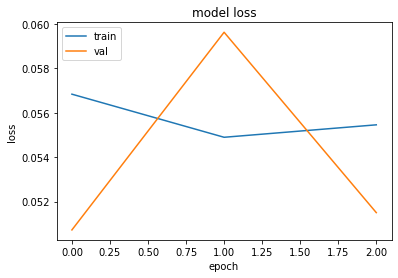

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate the trained classifier

In [48]:
val_loss, val_acc = genderClf.evaluate(validation_dataset, steps=val_steps)

55/55 [==============================] - 1149s 21s/step - loss: 0.0515 - accuracy: 0.9902


In [49]:
test_loss, test_acc = genderClf.evaluate(test_dataset, steps=eval_steps)

38/38 [==============================] - 746s 20s/step - loss: 0.0788 - accuracy: 0.9768


In [50]:
y_pred = genderClf.predict(test_dataset, steps=eval_steps)
print(y_pred.shape)

(1206, 1, 1)


In [51]:
# Probably need to reshape y_pred to format for classification report
y_pred = tf.squeeze(y_pred)
print(y_pred.shape)
print(y_pred[:10])

(1206,)
tf.Tensor(
[6.67009153e-04 4.68287726e-06 1.08570261e-02 9.74181574e-04
 2.89576419e-04 1.06606975e-01 1.08457659e-03 1.93000915e-06
 4.39342739e-06 9.99995708e-01], shape=(10,), dtype=float32)


In [53]:
gen_pred_3  = []
for i in y_pred:
  if i < 0.5:
    gen_pred_3.append(0)
  else: gen_pred_3.append(1)

print(gen_pred_3[:25])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]


In [58]:
# Get 1D array of labels from test_dataset
y_lab = np.concatenate([y for x, y in test_dataset.take(eval_steps)], axis=0)
print(len(y_lab))
print(y_lab[:25])

1206
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 1.]


In [55]:
tf.math.confusion_matrix(y_lab, gen_pred_3)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[601,   9],
       [ 19, 577]], dtype=int32)>

In [56]:
classification_report(y_lab, gen_pred_3)

'              precision    recall  f1-score   support\n\n         0.0       0.97      0.99      0.98       610\n         1.0       0.98      0.97      0.98       596\n\n    accuracy                           0.98      1206\n   macro avg       0.98      0.98      0.98      1206\nweighted avg       0.98      0.98      0.98      1206\n'

In [57]:
confusion_matrix(y_lab, gen_pred_3)

array([[601,   9],
       [ 19, 577]])

# Create a run a simpler, two layer model

In [42]:
genderClf_2layer = tf.keras.models.Sequential([
                              tf.keras.layers.Dense(128, activation = 'relu', input_shape=(10, 128)),
                              tf.keras.layers.Dense(1, activation='sigmoid'),
                              tf.keras.layers.AveragePooling1D(pool_size=10, strides=None, padding="valid", data_format="channels_last")
                              ])
genderClf_2layer.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])

In [43]:
# Add early stopping to train classifier model; default is 10 epochs
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=2)

In [44]:
# Add model checkpoints, in case training times out on the GPU
ckpt_path = 'model/gender/genderClf_2layer.ckpt'
ckpt_dir = os.path.dirname(ckpt_path)

ckpt = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

In [45]:
# If a trained model already exists, load it.
# If model checkpoints exist, load them.
# Else train a new model

if os.path.isdir('model/gender/genderClf_2layer'):
  genderClf = tf.keras.models.load_model('/model/gender/genderClf_2layer')
  hist_2df = pd.read_csv('model/gender/genderClf_2layer.history.csv')
else:
  if os.path.isfile('model/gender/genderClf_2layer.ckpt'):
    # Load model weights from the most recent checkpoint
    latest = tf.train.latest_checkpoint(ckpt_dir)
    genderClf_2layer.load_weights(latest)
  hist_2 = genderClf_2layer.fit(train_dataset, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=5, 
                        validation_data=validation_dataset, 
                        validation_steps = val_steps,
                        callbacks=[early_stopping_monitor, ckpt], 
                        batch_size=BATCH_SIZE)

Epoch 1/5
163/163 [==============================] - 4265s 26s/step - loss: 0.1452 - accuracy: 0.9682 - val_loss: 0.0622 - val_accuracy: 0.9884
Epoch 2/5
163/163 [==============================] - 2998s 18s/step - loss: 0.0641 - accuracy: 0.9888 - val_loss: 0.0570 - val_accuracy: 0.9890
Epoch 3/5
163/163 [==============================] - 2803s 17s/step - loss: 0.0615 - accuracy: 0.9888 - val_loss: 0.0544 - val_accuracy: 0.9884
Epoch 4/5
163/163 [==============================] - 2797s 17s/step - loss: 0.0602 - accuracy: 0.9881 - val_loss: 0.0530 - val_accuracy: 0.9890
Epoch 5/5
163/163 [==============================] - 2787s 17s/step - loss: 0.0586 - accuracy: 0.9894 - val_loss: 0.0554 - val_accuracy: 0.9879


In [ ]:
  hist_2 = genderClf_2layer.fit(train_dataset, 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=10, 
                        validation_data=validation_dataset, 
                        validation_steps = val_steps,
                        callbacks=[early_stopping_monitor, ckpt], 
                        batch_size=BATCH_SIZE)

Epoch 1/10
163/163 [==============================] - 2941s 18s/step - loss: 0.0583 - accuracy: 0.9892 - val_loss: 0.0521 - val_accuracy: 0.9902
Epoch 2/10
163/163 [==============================] - 2802s 17s/step - loss: 0.0576 - accuracy: 0.9892 - val_loss: 0.0518 - val_accuracy: 0.9902
Epoch 3/10
163/163 [==============================] - 2806s 17s/step - loss: 0.0571 - accuracy: 0.9892 - val_loss: 0.0514 - val_accuracy: 0.9908
Epoch 4/10
163/163 [==============================] - 2778s 17s/step - loss: 0.0572 - accuracy: 0.9898 - val_loss: 0.0527 - val_accuracy: 0.9890
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9890 

In [47]:
# Save the trained model and model history for use later
genderClf_2layer.save('model/gender/genderClf_2layer')

hist2_df = pd.DataFrame(hist_2.history) 

# save to csv: 
hist_csv_file = 'model/gender/genderClf_2layer.history.csv'
with open(hist_csv_file, mode='w') as f:
    hist2_df.to_csv(f)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: model/gender/genderClf_2layer/assets


INFO:tensorflow:Assets written to: model/gender/genderClf_2layer/assets


In [49]:
hist2_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.145186,0.968208,0.062173,0.988439
1,0.064087,0.988825,0.057022,0.989017
2,0.061530,0.988825,0.054381,0.988439
3,0.060174,0.988054,0.053013,0.989017
4,0.058634,0.989403,0.055375,0.987861


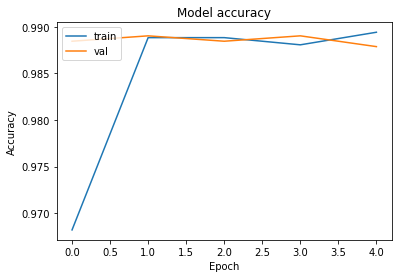

In [51]:
plt.plot(hist2_df['accuracy'])
plt.plot(hist2_df['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

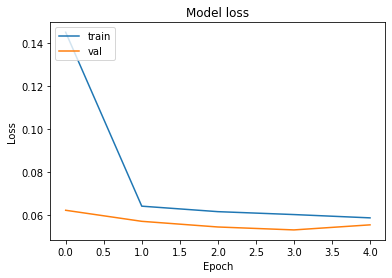

In [52]:
plt.plot(hist2_df['loss'])
plt.plot(hist2_df['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate the 2 layer classifier

In [53]:
val_loss, val_acc = genderClf_2layer.evaluate(validation_dataset, steps=val_steps)

55/55 [==============================] - 690s 13s/step - loss: 0.0554 - accuracy: 0.9879


In [54]:
test_loss, test_acc = genderClf_2layer.evaluate(test_dataset, steps=eval_steps)

38/38 [==============================] - 712s 19s/step - loss: 0.0808 - accuracy: 0.9776


In [55]:
y_pred_2 = genderClf_2layer.predict(test_dataset, steps=eval_steps)
print(y_pred_2.shape)

(1206, 1, 1)


In [56]:
gen_pred_2  = []
for i in y_pred_2:
  if i < 0.5:
    gen_pred_2.append(0)
  else: gen_pred_2.append(1)

print(gen_pred_2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

In [59]:
tf.math.confusion_matrix(y_lab, gen_pred_2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[603,   7],
       [ 20, 576]], dtype=int32)>